#GENA-LM on bulk data

## Imports and functions

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

Mounted at /content/drive


In [ ]:
!pip uninstall -y transformers accelerate
!pip install transformers accelerate
!pip install datasets
!pip install transformers
!pip install wandb

Found existing installation: transformers 4.30.1
Uninstalling transformers-4.30.1:
  Successfully uninstalled transformers-4.30.1
Found existing installation: accelerate 0.20.3
Uninstalling accelerate-0.20.3:
  Successfully uninstalled accelerate-0.20.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.30.1-py3-none-any.whl (7.2 MB)
  Using cached accelerate-0.20.3-py3-none-any.whl (227 kB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, roc_auc_score, matthews_corrcoef
import datasets
from transformers import AutoTokenizer, BigBirdForSequenceClassification, AutoModelForSequenceClassification, AutoModel
import torch
import transformers
from torch.nn import BCEWithLogitsLoss
from transformers import BigBirdTokenizer, BigBirdForSequenceClassification, EvalPrediction, AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from torch.utils.data import Dataset, DataLoader
import wandb
import random

In [ ]:
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = 'max_length', truncation=True, max_length = 3072)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # argmax(pred.predictions, axis=1)
    #pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = balanced_accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)
    return {
        'balanced_accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'mcc': mcc
    }

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('AIRI-Institute/gena-lm-bigbird-base-t2t')
model = BigBirdForSequenceClassification.from_pretrained('AIRI-Institute/gena-lm-bigbird-base-t2t')

Some weights of the model checkpoint at AIRI-Institute/gena-lm-bigbird-base-t2t were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassification were not initialized from the model checkpo

In [ ]:
model

BigBirdForSequenceClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=3)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
for i, layer in enumerate(model.children()):
  if i < 1:
    for param in layer.parameters():
      param.requires_grad = False

##Prepare data

We used bed2fasta https://meme-suite.org/meme/tools/bed2fasta to extract sequences using the coordinates from https://github.com/QiaoyingJi/DeepSE. Here we choose UCSC mammalian genomes, Human and hg19 (for mm1.s, h2171, u87).

Reading data

In [ ]:
dataset1 = pd.read_csv('./data/f_u87.сsv')
dataset2 = pd.read_csv('./data/f_MM1.S.сsv')
dataset3 = pd.read_csv('./data/f_H2171.сsv')

dataset = pd.concat([dataset1, dataset2, dataset3])

In [ ]:
SE_dataset = dataset[dataset['0'] == 1]
TE_dataset = dataset[dataset['0'] != 1]

positive_seqs = list(SE_dataset['Unnamed: 0'])
negative_seqs = list(TE_dataset['Unnamed: 0'])

In [ ]:
l = len(positive_seqs)
all_seqs = positive_seqs.copy()
all_seqs.extend(negative_seqs)
len(all_seqs)

49079

In [ ]:
labels = []
for i in range(len(all_seqs)):
  if i < l:

    labels.append(1)
  else:
    labels.append(0)

In [ ]:
data_dict = {'sequence' : all_seqs, 'SE_presence' : labels}

df = pd.DataFrame.from_dict(data_dict)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
data = df

Train-test split

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_text_df = pd.DataFrame({'text': train_data['sequence'], 'label': train_data['SE_presence']})
test_text_df = pd.DataFrame({'text': test_data['sequence'], 'label': test_data['SE_presence']})
train_text_df = train_text_df.reset_index(drop=True)
test_text_df = test_text_df.reset_index(drop=True)

train_dataset = datasets.Dataset.from_pandas(train_text_df)
test_dataset = datasets.Dataset.from_pandas(test_text_df)

To prevent data leakage due to the difference in the distributions of the lengths of tokenized sequences, we approximated the distributions by dividing the data into bins and collecting data from TE dataset so that the distributions were close

In [ ]:
train_tl = train_data.copy()
tokens = []
for i in train_tl['sequence']:
  tokens.append(len(tokenizer.tokenize(i)))
tokens = np.array(tokens)

train_tl['tl'] = tokens

train_tl_SE = train_tl[train_tl.SE_presence == 1]
train_tl_TE = train_tl[train_tl.SE_presence == 0]

In [ ]:
np.min(train_tl_SE.tl)

226

In [ ]:
np.max(train_tl_SE.tl)

17134

In [ ]:
TE_data = train_tl[:0]

In [ ]:
for i in range(200, 17200, 50):
  bin = len(train_tl_SE[train_tl_SE.tl > i-50][train_tl_SE.tl <= i])
  TEs = train_tl_TE[train_tl_TE.tl > i-50][train_tl_TE.tl <= i][:bin]
  TE_data = pd.concat([TE_data, TEs])

<ipython-input-29-6f50ed554ee3>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TEs = train_tl_TE[train_tl_TE.tl > i-50][train_tl_TE.tl <= i][:bin]
<ipython-input-29-6f50ed554ee3>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TEs = train_tl_TE[train_tl_TE.tl > i-50][train_tl_TE.tl <= i][:bin]
<ipython-input-29-6f50ed554ee3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bin = len(train_tl_SE[train_tl_SE.tl > i-50][train_tl_SE.tl <= i])
<ipython-input-29-6f50ed554ee3>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  TEs = train_tl_TE[train_tl_TE.tl > i-50][train_tl_TE.tl <= i][:bin]
<ipython-input-29-6f50ed554ee3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bin = len(train_tl_SE[train_tl_SE.tl > i-50][train_tl_SE.tl <= i])
<ipython-input-29-6f50ed554ee3>:3: UserWarning: Boolean Series key will be reindexed to match Dat

In [ ]:
train = pd.concat([train_tl_SE, TE_data])

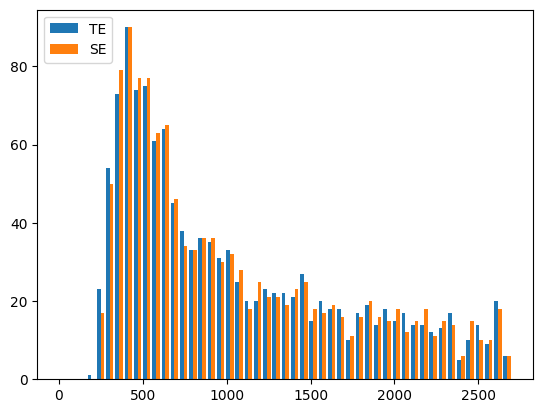

In [ ]:
SE_tokens = []
for i in train[train['SE_presence']==1]['sequence']:
  SE_tokens.append(len(tokenizer.tokenize(i)))
SE_tokens = np.array(SE_tokens)

TE_tokens = []
for i in train[train['SE_presence']==0]['sequence']:
  TE_tokens.append(len(tokenizer.tokenize(i)))
TE_tokens = np.array(TE_tokens)

bins = np.linspace(0, 2700, 50)
pyplot.hist([TE_tokens, SE_tokens], bins, label=['TE', 'SE'])
pyplot.legend(loc='upper left')
pyplot.show()

In [ ]:
train_data = train.sample(frac=1)

In [ ]:
train_text_df = pd.DataFrame({'text': train_data['sequence'], 'label': train_data['SE_presence']})
train_text_df = train_text_df.reset_index(drop=True)
train_dataset = datasets.Dataset.from_pandas(train_text_df)

Tokenization:

In [ ]:
train_dataset = train_dataset.map(tokenization, batched = True, batch_size = len(train_dataset))
test_dataset = test_dataset.map(tokenization, batched = True, batch_size = len(test_dataset))

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3266 [00:00<?, ? examples/s]

Map:   0%|          | 0/9816 [00:00<?, ? examples/s]

## Fine-tuning of classifier

In [ ]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 5,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 32,
    per_device_eval_batch_size= 16,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    disable_tqdm = False,
    load_best_model_at_end=True,
    warmup_steps=160,
    weight_decay=0.01,
    logging_steps = 5,
    learning_rate = 1e-4,
    fp16 = True,
    logging_dir='./log',
    dataloader_num_workers = 0,
    run_name = 'bigbird_classification_classificator'
)

In [ ]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Balanced Accuracy,F1,Precision,Recall,Auc,Mcc
0,0.693500,0.717940,0.500000,0.003694,0.001928,0.043908,0.500000,0.000000
1,0.693100,0.703382,0.511722,0.084861,0.937819,0.085371,0.511722,0.023602
2,0.694400,0.692322,0.578924,0.628697,0.929667,0.499593,0.578924,0.064712
3,0.693100,0.672476,0.572939,0.862204,0.924677,0.814079,0.572939,0.079736
4,0.689400,0.688130,0.597301,0.683225,0.931030,0.562245,0.597301,0.080151


TrainOutput(global_step=255, training_loss=0.6918901032092525, metrics={'train_runtime': 9517.1489, 'train_samples_per_second': 1.716, 'train_steps_per_second': 0.027, 'total_flos': 2.594149066211328e+16, 'train_loss': 0.6918901032092525, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6724762916564941,
 'eval_balanced_accuracy': 0.5729391201589148,
 'eval_f1': 0.8622040065307441,
 'eval_precision': 0.9246767845973769,
 'eval_recall': 0.814079054604727,
 'eval_auc': 0.5729391201589148,
 'eval_mcc': 0.07973585158833997,
 'eval_runtime': 1398.4399,
 'eval_samples_per_second': 7.019,
 'eval_steps_per_second': 0.439,
 'epoch': 5.0}

In [ ]:
# save the best model
trainer.model.save_pretrained('./results/bigbird_base')
tokenizer.save_pretrained('./results/bigbird_base')

## Fine-tuning of the full model

In [ ]:
from transformers import AutoTokenizer, BigBirdForSequenceClassification, AutoModelForSequenceClassification, AutoModel

tokenizer = AutoTokenizer.from_pretrained('./results/bigbird_base')
model = AutoModelForSequenceClassification.from_pretrained('./results/bigbird_base')

In [ ]:
for i, layer in enumerate(model.children()):
  for param in layer.parameters():
    param.requires_grad = True

In [ ]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = './results__bert',
    num_train_epochs = 5,
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 32,
    per_device_eval_batch_size= 1,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    disable_tqdm = False,
    load_best_model_at_end=True,
    warmup_steps=160,
    weight_decay=0.01,
    logging_steps = 5,
    learning_rate = 1e-5,
    fp16 = True,
    logging_dir='./log_bert',
    dataloader_num_workers = 0,
    run_name = 'bigbird_classification_bert'
)

In [ ]:
trainer2 = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
trainer2.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Balanced Accuracy,F1,Precision,Recall,Auc,Mcc
0,0.669800,0.598846,0.635613,0.864345,0.932093,0.815403,0.635613,0.144900
1,0.703800,0.649548,0.643105,0.735995,0.936097,0.628667,0.643105,0.120497


Epoch,Training Loss,Validation Loss,Balanced Accuracy,F1,Precision,Recall,Auc,Mcc
0,0.669800,0.598846,0.635613,0.864345,0.932093,0.815403,0.635613,0.144900
1,0.703800,0.649548,0.643105,0.735995,0.936097,0.628667,0.643105,0.120497
2,0.586200,0.534853,0.625749,0.833559,0.931170,0.766911,0.625749,0.122346
3,0.627800,0.498147,0.601045,0.840947,0.928094,0.778932,0.601045,0.101164
4,0.503800,0.506175,0.607076,0.837592,0.928853,0.773533,0.607076,0.105948


TrainOutput(global_step=510, training_loss=0.6183492520276238, metrics={'train_runtime': 19140.4666, 'train_samples_per_second': 0.853, 'train_steps_per_second': 0.027, 'total_flos': 2.594149066211328e+16, 'train_loss': 0.6183492520276238, 'epoch': 5.0})

In [ ]:
trainer2.evaluate()

{'eval_loss': 0.4981469213962555,
 'eval_balanced_accuracy': 0.6010450106120371,
 'eval_f1': 0.840946852029025,
 'eval_precision': 0.9280944670757498,
 'eval_recall': 0.7789323553382234,
 'eval_auc': 0.601045010612037,
 'eval_mcc': 0.10116399395337015,
 'eval_runtime': 1527.442,
 'eval_samples_per_second': 6.426,
 'eval_steps_per_second': 6.426,
 'epoch': 5.0}

In [ ]:
trainer2.model.save_pretrained('./results_bert/bigbird_base')
tokenizer.save_pretrained('./results_bert/bigbird_base')

('/content/drive/MyDrive/SE_annotation_project/bulk/results_bert/bigbird_base/tokenizer_config.json',
 '/content/drive/MyDrive/SE_annotation_project/bulk/results_bert/bigbird_base/special_tokens_map.json',
 '/content/drive/MyDrive/SE_annotation_project/bulk/results_bert/bigbird_base/tokenizer.json')